# Intestinal organoid differentiation - Kinetic rate change over (pseudo)time

## Library imports

In [1]:
import os
import sys

import pandas as pd
from scipy.sparse import csr_matrix

import cellrank as cr
import scanpy as sc
import scvelo as scv

from cr2 import running_in_notebook

sys.path.extend(["../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

Global seed set to 0


## General settings

In [2]:
sc.settings.verbosity = 3
scv.settings.verbosity = 3

In [3]:
scv.settings.set_figure_params("scvelo", dpi_save=400, transparent=True, color_map="viridis")

In [4]:
SAVE_FIGURES = False

if SAVE_FIGURES:
    os.makedirs(FIG_DIR / "labeling_kernel", exist_ok=True)

## Data loading

In [5]:
adata = sc.read(DATA_DIR / "sceu_organoid" / "processed" / "preprocessed.h5ad")

adata.layers["alpha"] = pd.read_csv(DATA_DIR / "sceu_organoid" / "results" / "alpha.csv", index_col=0).values
adata.layers["gamma"] = pd.read_csv(DATA_DIR / "sceu_organoid" / "results" / "gamma.csv", index_col=0).values
adata.layers["r0"] = pd.read_csv(DATA_DIR / "sceu_organoid" / "results" / "r0.csv", index_col=0).values

velo_pseudotime = pd.read_csv(DATA_DIR / "sceu_organoid" / "results" / "velocity_pseudotime.csv", index_col=0)
velo_pseudotime.index = velo_pseudotime.index.astype(str)
adata.obs = adata.obs.merge(velo_pseudotime, left_index=True, right_index=True)
del velo_pseudotime

adata

AnnData object with n_obs × n_vars = 3452 × 2000
    obs: 'experiment', 'labeling_time', 'cell_type', 'som_cluster_id', 'cell_type_merged', 'initial_size', 'n_counts', 'velocity_pseudotime'
    var: 'ensum_id', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_umap_paper'
    varm: 'PCs'
    layers: 'labeled', 'total', 'unlabeled', 'alpha', 'gamma', 'r0'
    obsp: 'connectivities', 'distances'

In [6]:
goblet_markers = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "goblet_markers.csv")["Gene"].str.lower().tolist()
)

goblet_markers = adata.var_names[adata.var_names.str.lower().isin(goblet_markers)]

## Data preprocessing

In [7]:
adata.layers["labeled_smoothed"] = csr_matrix.dot(adata.obsp["connectivities"], adata.layers["labeled"]).A

In [8]:
adata.layers["alpha_smoothed"] = csr_matrix.dot(adata.obsp["connectivities"], adata.layers["alpha"])
adata.layers["gamma_smoothed"] = csr_matrix.dot(adata.obsp["connectivities"], adata.layers["gamma"])
adata.layers["r0_smoothed"] = csr_matrix.dot(adata.obsp["connectivities"], adata.layers["r0"])

In [9]:
adata.layers["velocity_labeled"] = adata.layers["alpha"] - adata.layers["gamma"] * adata.layers["labeled_smoothed"]

## CellRank

In [10]:
vk = cr.kernels.VelocityKernel(adata, xkey="labeled_smoothed", vkey="velocity_labeled").compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()

combined_kernel = 0.8 * vk + 0.2 * ck

  0%|          | 0/3452 [00:00<?, ?cell/s]

  0%|          | 0/3452 [00:00<?, ?cell/s]

### Estimator analysis

In [11]:
estimator = cr.estimators.GPCCA(combined_kernel)

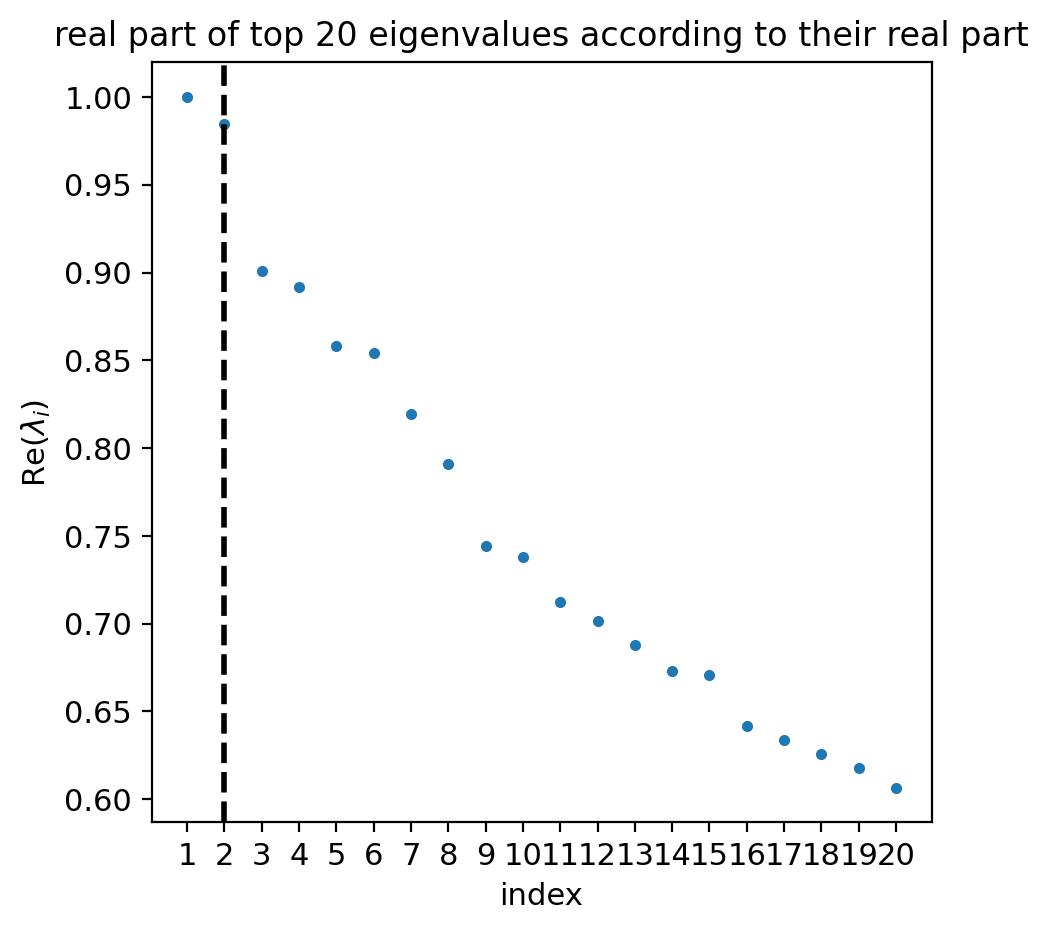

In [12]:
estimator.compute_schur(n_components=20)
if running_in_notebook():
    estimator.plot_spectrum(real_only=True)

#### Macrostates

In [13]:
estimator.compute_macrostates(n_states=12, cluster_key="cell_type")

GPCCA[kernel=(0.8 * VelocityKernel[n=3452] + 0.2 * ConnectivityKernel[n=3452]), initial_states=None, terminal_states=None]

In [14]:
estimator.set_terminal_states(states=["Enterocytes", "Paneth cells", "Enteroendocrine progenitors", "Goblet cells"])
terminal_states = estimator.terminal_states.cat.categories

#### Fate probabilities

In [15]:
estimator.compute_fate_probabilities()

  0%|          | 0/4 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


### Driver analysis

In [16]:
gene_ranks = {terminal_state: pd.DataFrame() for terminal_state in terminal_states}
gene_ranks_gex = {terminal_state: pd.DataFrame() for terminal_state in terminal_states}

In [17]:
drivers = {}
for terminal_state in terminal_states:
    drivers[terminal_state] = estimator.compute_lineage_drivers(
        layer="alpha",
        cluster_key="cell_type",
        lineages=[terminal_state],
        clusters=["Stem cells", terminal_state],
        return_drivers=True,
    )
    drivers[terminal_state] = drivers[terminal_state].merge(
        pd.DataFrame(drivers[terminal_state].sort_values(by=f"{terminal_state}_corr", ascending=False).index)
        .reset_index()
        .rename({"index": f"Corr. rank - {terminal_state}", 0: "Gene"}, axis=1)
        .set_index("Gene"),
        left_index=True,
        right_index=True,
    )

drivers = pd.concat(drivers.values(), axis=1)

In [18]:
drivers_gex = {}
for terminal_state in terminal_states:
    drivers_gex[terminal_state] = estimator.compute_lineage_drivers(
        layer="labeled_smoothed",
        cluster_key="cell_type",
        lineages=[terminal_state],
        clusters=["Stem cells", terminal_state],
        return_drivers=True,
    )
    drivers_gex[terminal_state] = drivers_gex[terminal_state].merge(
        pd.DataFrame(drivers_gex[terminal_state].sort_values(by=f"{terminal_state}_corr", ascending=False).index)
        .reset_index()
        .rename({"index": f"Corr. rank - {terminal_state}", 0: "Gene"}, axis=1)
        .set_index("Gene"),
        left_index=True,
        right_index=True,
    )

drivers_gex = pd.concat(drivers_gex.values(), axis=1)

## Parameters vs pseudotime

In [19]:
"""
sorted_genes = drivers["Corr. rank - Goblet cells"].sort_values()
var_names = sorted_genes[sorted_genes.index.isin(goblet_markers) & (sorted_genes < 100)].index
"""
cooperative_genes = [
    "Sytl2",
    "Fcgbp",
    "Spink4",
    "Rap1gap",
    "Fry",
    "Galnt5",
    "Agr2",
    "Ttc39a",
    "Creld2",
    "Defa17",
    "Fxyd3",
    "Tmco3",
    "Hid1",
    "Cracr2a",
]
destructive_genes = ["Syt7", "Atp2c2", "Slc12a8", "Atp2a3", "Spdef", "Tfcp2l1", "Tff3", "Rassf6"]
var_names = cooperative_genes + destructive_genes

  0%|          | 0/22 [00:00<?, ?gene/s]

Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/22 [00:00<?, ?gene/s]

  0%|          | 0/22 [00:00<?, ?gene/s]

did not converge


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/22 [00:00<?, ?gene/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


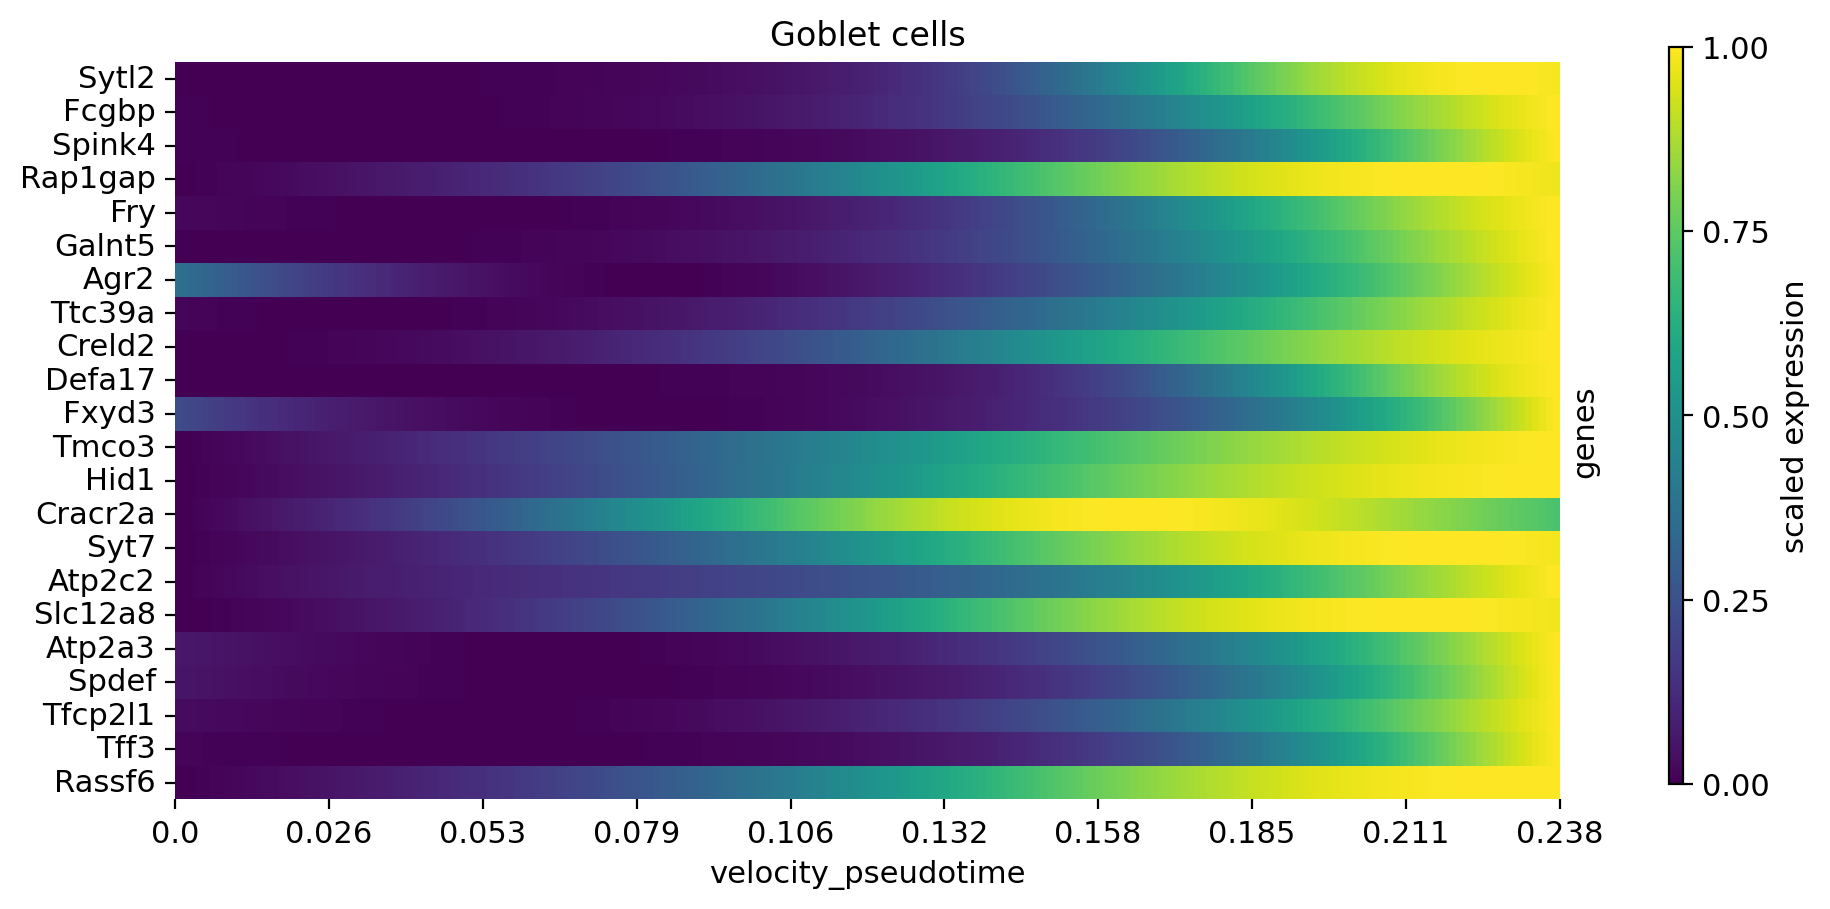

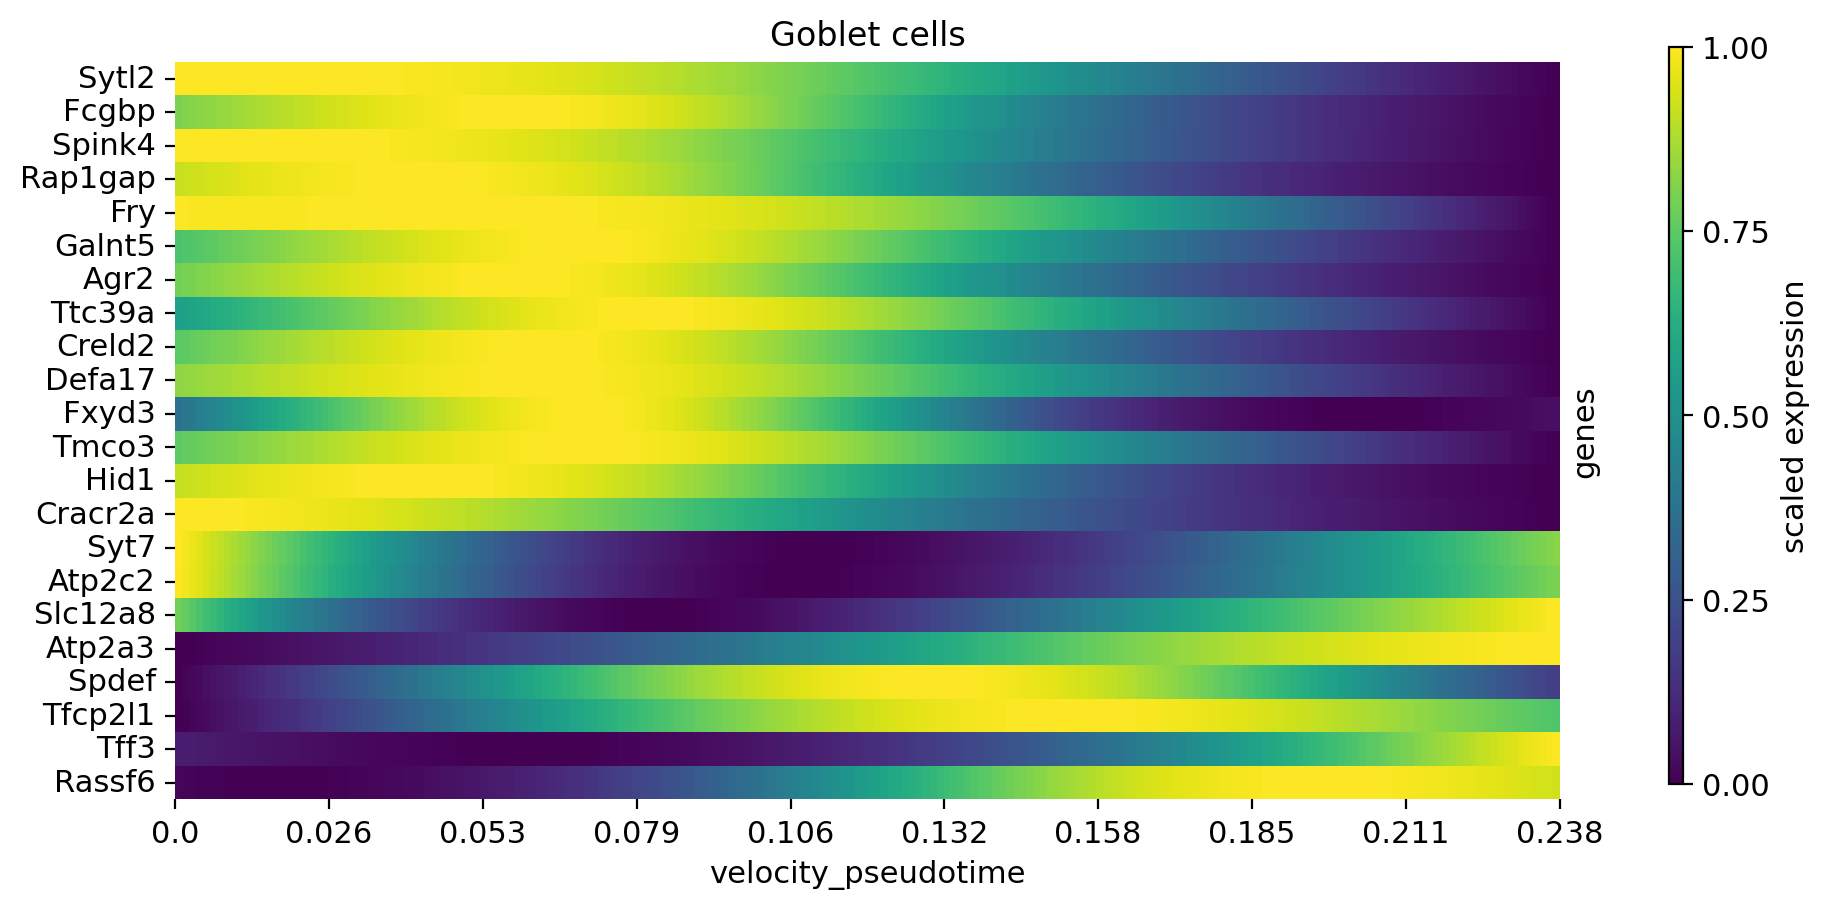

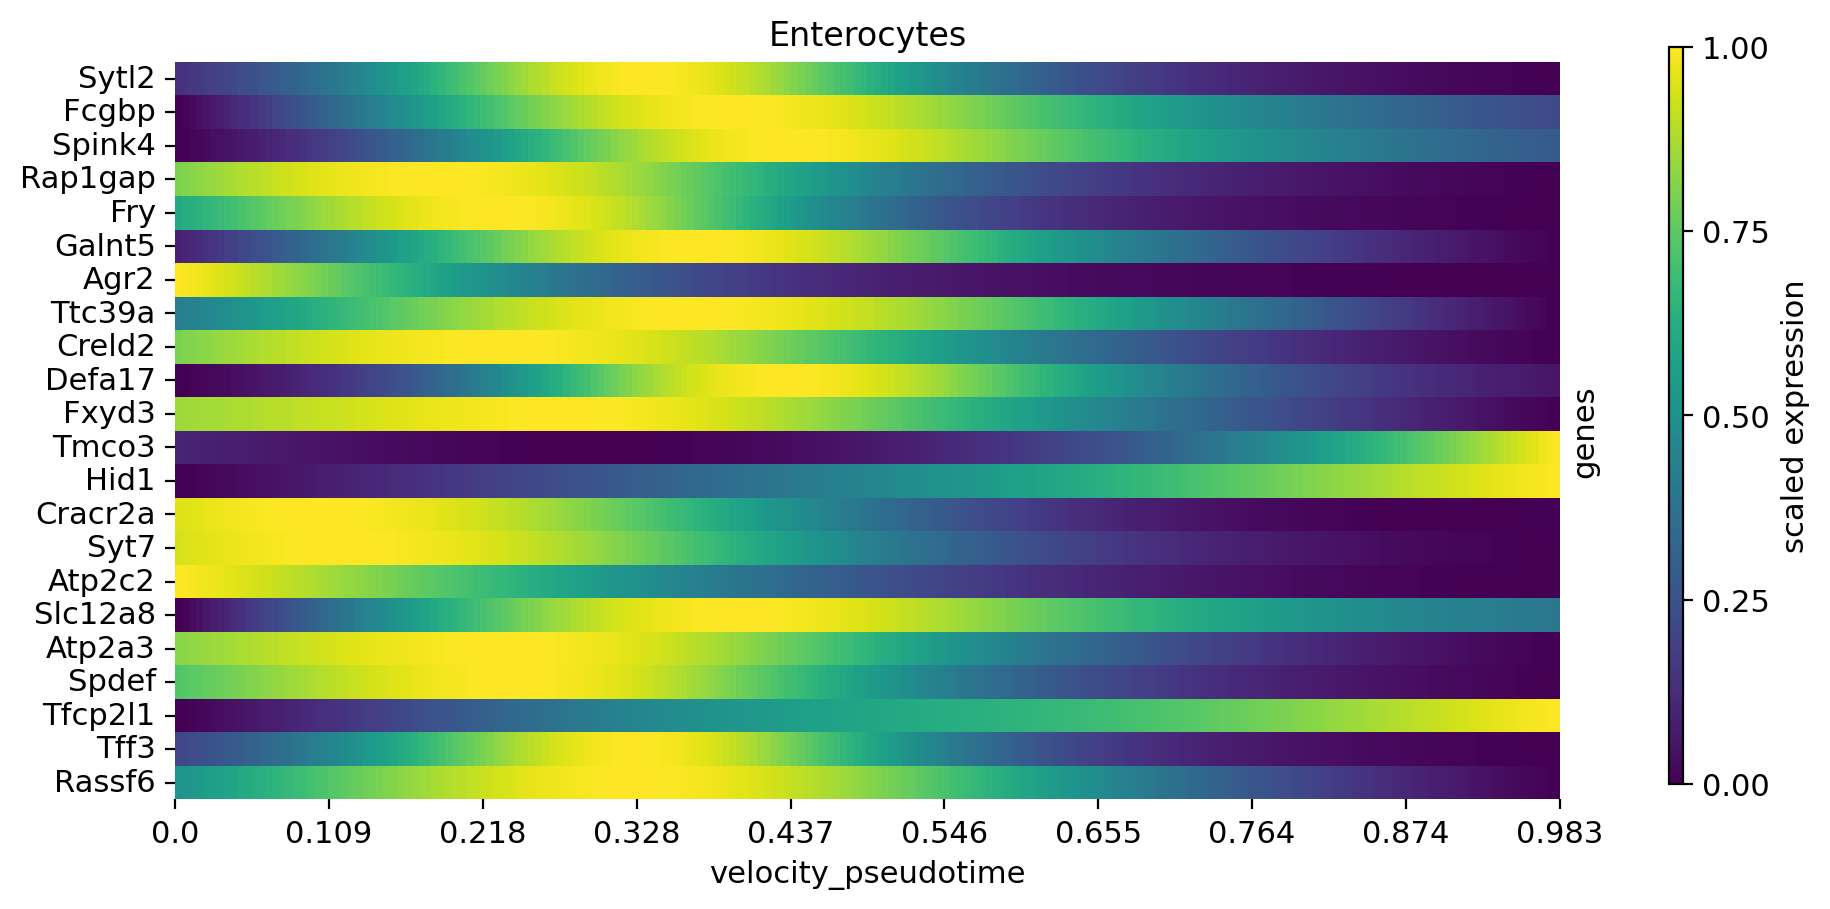

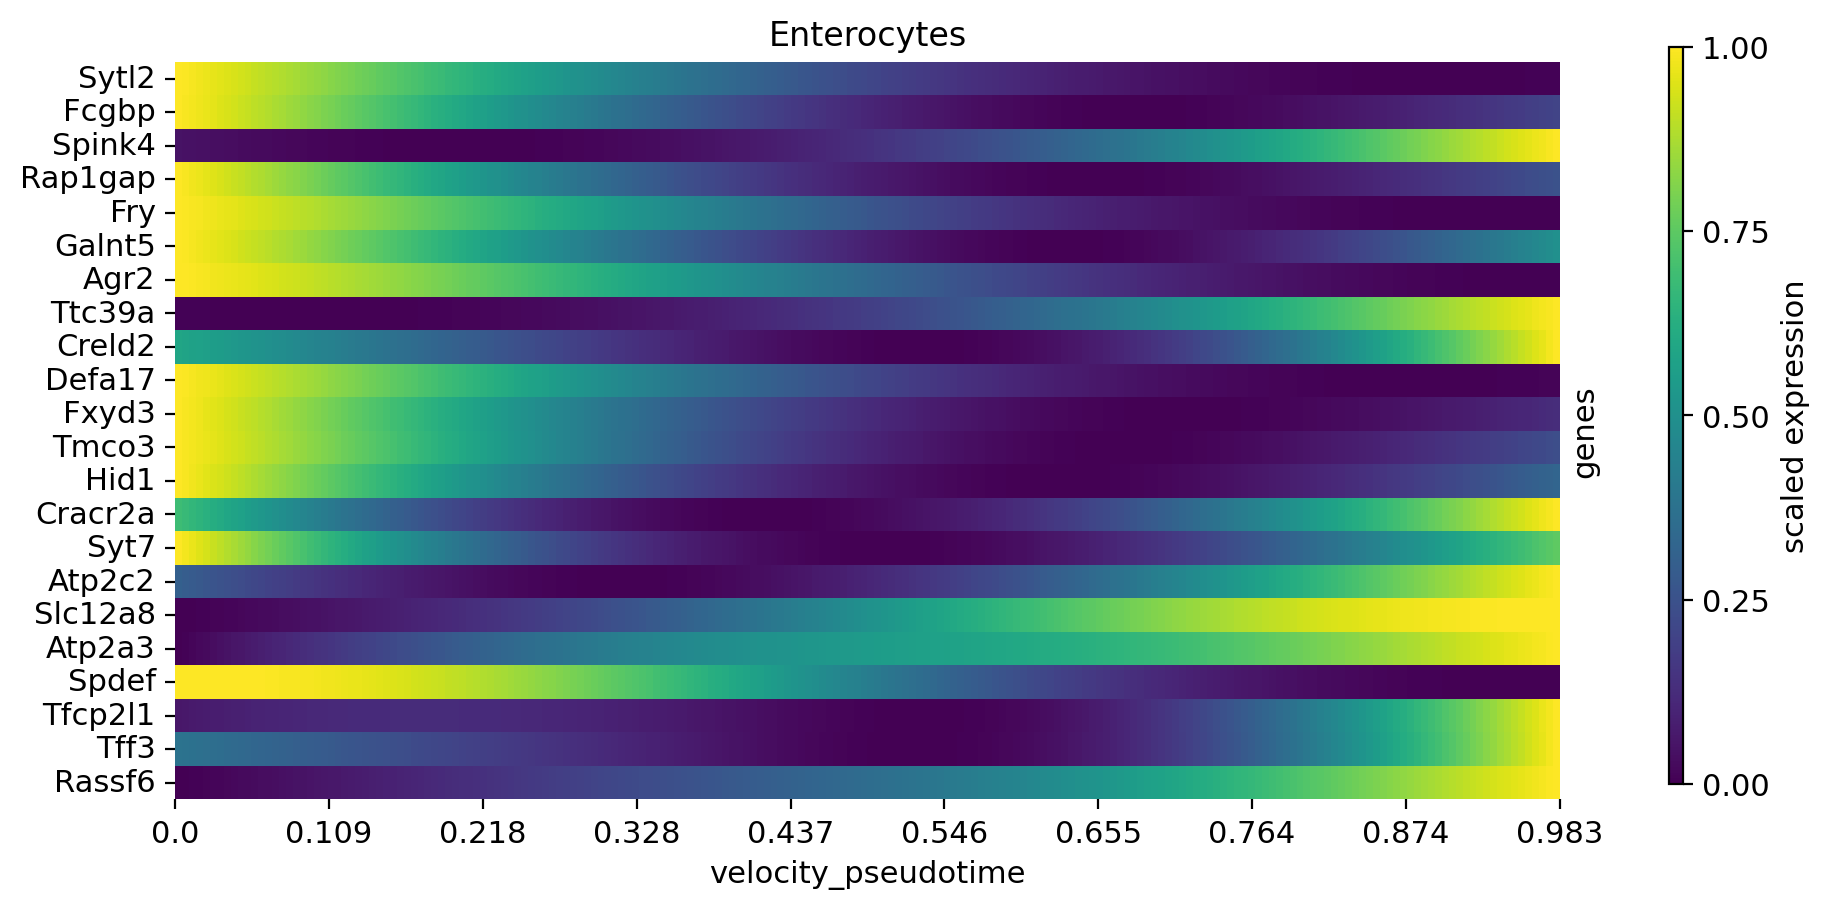

In [20]:
model = cr.models.GAM(adata)

if SAVE_FIGURES:
    save = FIG_DIR / "labeling_kernel" / "heatmap_transcription_rate_goblet_markers-goblet_lineage.png"
else:
    save = None
cr.pl.heatmap(
    adata,
    model,
    data_key="alpha_smoothed",
    genes=var_names,
    gene_order=var_names,
    show_fate_probabilities=False,
    show_all_genes=True,
    lineages="Goblet cells",
    time_key="velocity_pseudotime",
    figsize=(10, 5),
    n_jobs=8,
    save=save,
)

if SAVE_FIGURES:
    save = FIG_DIR / "labeling_kernel" / "heatmap_degradation_rate_goblet_markers-goblet_lineage.png"
else:
    save = None
cr.pl.heatmap(
    adata,
    model,
    data_key="gamma_smoothed",
    genes=var_names,
    gene_order=var_names,
    show_fate_probabilities=False,
    show_all_genes=True,
    lineages="Goblet cells",
    time_key="velocity_pseudotime",
    figsize=(10, 5),
    n_jobs=8,
    save=save,
)

if SAVE_FIGURES:
    save = FIG_DIR / "labeling_kernel" / "heatmap_transcription_rate_goblet_markers-enterocyte_lineage.png"
else:
    save = None
cr.pl.heatmap(
    adata,
    model,
    data_key="alpha_smoothed",
    genes=var_names,
    gene_order=var_names,
    show_fate_probabilities=False,
    show_all_genes=True,
    lineages="Enterocytes",
    time_key="velocity_pseudotime",
    figsize=(10, 5),
    n_jobs=8,
    save=save,
)

if SAVE_FIGURES:
    save = FIG_DIR / "labeling_kernel" / "heatmap_degradation_rate_goblet_markers-enterocyte_lineage.png"
else:
    save = None
cr.pl.heatmap(
    adata,
    model,
    data_key="gamma_smoothed",
    genes=var_names,
    gene_order=var_names,
    show_fate_probabilities=False,
    show_all_genes=True,
    lineages="Enterocytes",
    time_key="velocity_pseudotime",
    figsize=(10, 5),
    n_jobs=8,
    save=save,
)